In [3]:
pip install squarify

In [4]:
# import relevant libraries
%matplotlib inline
import json
import pandas as pd  # Import pandas
from pandas import json_normalize  # Import json_normalize directly from pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import OffsetImage
import squarify
from functools import reduce

##### 1. Draw a simple pitch

In [5]:
def draw_pitch(ax):
    # size of the pitch is 120, 80
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color="black")
    plt.plot([0,14.6],[57.8,57.8],color="black")
    plt.plot([0,14.6],[22.2,22.2],color="black")

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color="black")
    plt.plot([105.4,105.4],[57.8,22.5],color="black")
    plt.plot([120, 105.4],[22.5,22.5],color="black")

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color="black")
    plt.plot([4.9,4.9],[48,32],color="black")
    plt.plot([0,4.9],[32,32],color="black")

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color="black")
    plt.plot([115.1,115.1],[48,32],color="black")
    plt.plot([120,115.1],[32,32],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

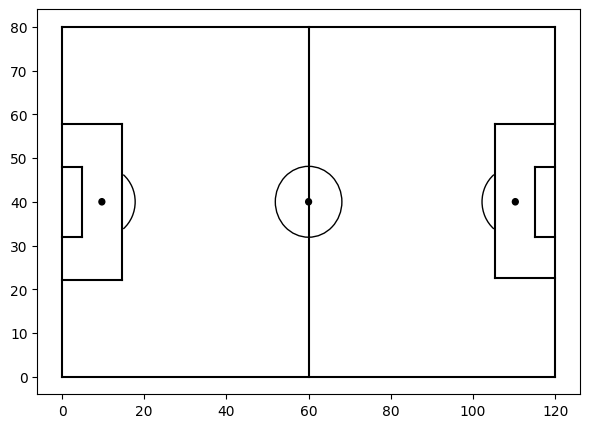

In [6]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.show()

##### 2. Drawing PassMap

We look at Mesut Ozil's Passes in the match between Germany and South Korea, where he received lots of criticism

In [7]:
# loading the json file
with open('7567.json') as data_file:
    data = json.load(data_file)

In [8]:
df = json_normalize(data, sep = "_")
ozil_pass = df[(df['type_name'] == "Pass") & (df['player_name']=='Mesut Özil')] # get passing information of Ozil
pass_column = [i for i in df.columns if i.startswith("pass")]
ozil_pass = ozil_pass[["id", "period", "timestamp", "location", "pass_end_location", "pass_recipient_name"]]
ozil_pass.head()

,id,period,timestamp,location,pass_end_location,pass_recipient_name
4,4acb528a-81bc-4d0c-be71-b010e6d7b70f,1,00:00:00.187,"[61.0, 41.0]","[49.0, 35.0]",Toni Kroos
12,5b536b03-efc9-41d9-b3a4-5e11f18767e7,1,00:00:04.200,"[55.0, 43.0]","[37.0, 59.0]",Niklas Süle
145,48519902-f4d4-4802-a74a-ae60a4e2ba5c,1,00:02:53.600,"[65.0, 23.0]","[71.0, 27.0]",Marco Reus
168,be75a05a-fb29-4105-b247-886d67e3a364,1,00:03:03.517,"[60.0, 25.0]","[56.0, 38.0]",Sami Khedira
187,952c3540-0d69-4db8-ad26-e8770d3a500d,1,00:03:15.080,"[67.0, 45.0]","[56.0, 32.0]",Toni Kroos


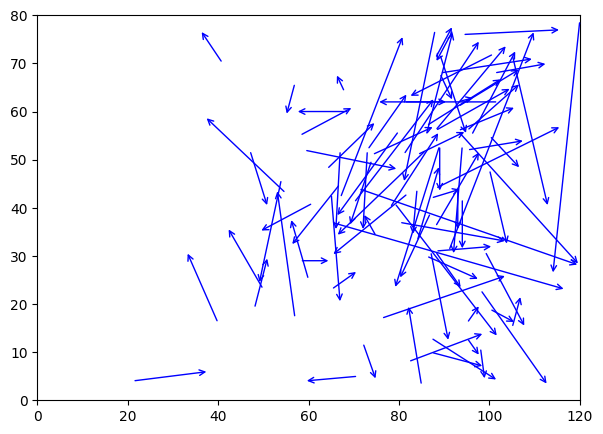

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
ax.set_xlim([0,120])
ax.set_ylim([0,80])
for i in range(len(ozil_pass)):
    # can also differentiate by color
    color = "blue" if ozil_pass.iloc[i]['period'] == 1 else "red"
    ax.annotate("", xy = (ozil_pass.iloc[i]['pass_end_location'][0], ozil_pass.iloc[i]['pass_end_location'][1]), xycoords = 'data',
               xytext = (ozil_pass.iloc[i]['location'][0], ozil_pass.iloc[i]['location'][1]), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)
plt.show()

#### 3. Drawing a Heatmap

In [11]:
# extract players involvement in the entire game
ozil_action = df[(df['player_name']=='Mesut Özil')][["id", "type_name","period", "timestamp", "location"]]
ozil_action.head()

,id,type_name,period,timestamp,location
4,4acb528a-81bc-4d0c-be71-b010e6d7b70f,Pass,1,00:00:00.187,"[61.0, 41.0]"
10,83c02b2d-65a1-47e1-ab6c-12a30a0ca397,Ball Receipt*,1,00:00:02.960,"[58.0, 42.0]"
11,64a2eb41-4037-43ad-ac38-56f53c9feb91,Carry,1,00:00:02.960,"[58.0, 42.0]"
12,5b536b03-efc9-41d9-b3a4-5e11f18767e7,Pass,1,00:00:04.200,"[55.0, 43.0]"
79,39dcba8e-0e08-41d2-a951-3780f64b784e,Interception,1,00:01:36.080,"[12.0, 28.0]"


<ipython-input-13-f648af1ae9c6>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_coord, y=y_coord, shade = "True", color = "green", n_levels = 30)


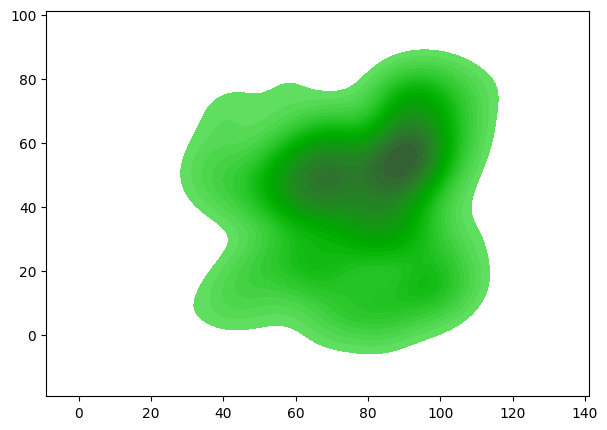

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)

x_coord = [i[0] for i in ozil_action["location"]]
y_coord = [i[1] for i in ozil_action["location"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more bluerry it loos
# Pass x and y as keyword arguments
sns.kdeplot(x=x_coord, y=y_coord, shade = "True", color = "green", n_levels = 30)
plt.show()

We now put both the heat map and the pass map together, with a nice pitch at the background

In [23]:
def heat_pass_map(data, player_name):
    pass_data = data[(data['type_name'] == "Pass") & (data['player_name'] == player_name)]
    action_data = data[(data['player_name']==player_name)]

    fig=plt.figure()
    fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)
    draw_pitch(ax)
    plt.axis('off')

    for i in range(len(pass_data)):
        # we also differentiate different half by different color
        color = "blue" if pass_data.iloc[i]['period'] == 1 else "red"
        ax.annotate("", xy = (pass_data.iloc[i]['pass_end_location'][0], pass_data.iloc[i]['pass_end_location'][1]), xycoords = 'data',
               xytext = (pass_data.iloc[i]['location'][0], pass_data.iloc[i]['location'][1]), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = color),)
    x_coord = [i[0] for i in action_data["location"]]
    y_coord = [i[1] for i in action_data["location"]]
    # Pass x_coord and y_coord as keyword arguments 'x' and 'y'
    sns.kdeplot(x=x_coord, y=y_coord, shade = "True", color = "green", n_levels = 30)
    plt.ylim(0, 80) # need this, otherwise kde plot will go outside
    plt.xlim(0, 120)
    plt.show()

<ipython-input-23-f691bd878403>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_coord, y=y_coord, shade = "True", color = "green", n_levels = 30)


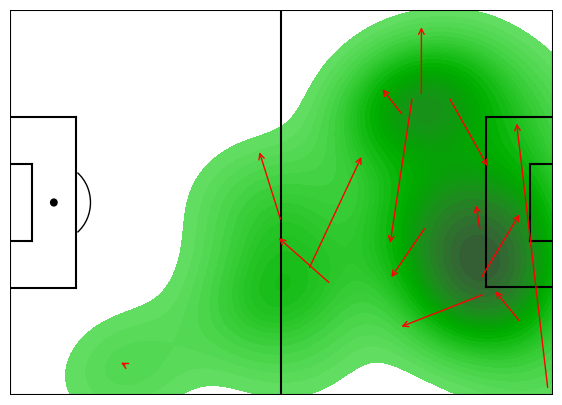

In [24]:
heat_pass_map(df, 'Thomas Müller')

<ipython-input-23-f691bd878403>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_coord, y=y_coord, shade = "True", color = "green", n_levels = 30)


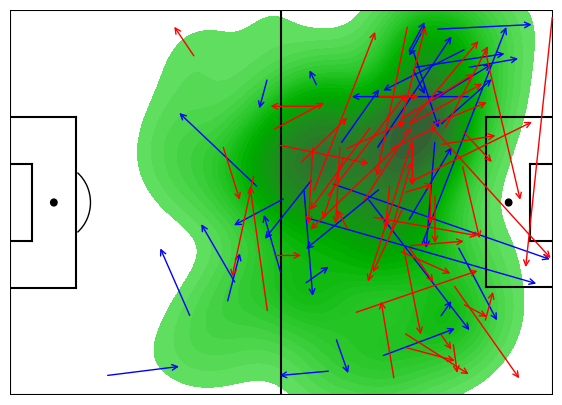

In [25]:
heat_pass_map(df, 'Mesut Özil')
# we can see that Ozil really struggles to play direct attacking ball in the first half, while he was a lot more direct in the second half

<ipython-input-23-f691bd878403>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_coord, y=y_coord, shade = "True", color = "green", n_levels = 30)


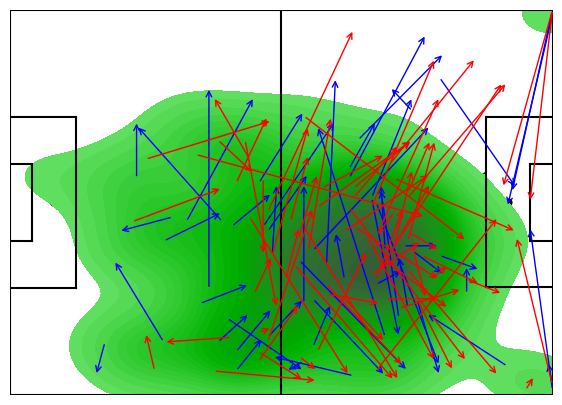

In [26]:
heat_pass_map(df, 'Toni Kroos')

##### France team

I want to plot out the shots from all different angles of the France team at the World Cup

In [32]:
import json
import pandas as pd
from pandas import json_normalize

data_id = [7546, 7563, 8655, 8658, 7530, 7580, 8649]
all_france = pd.DataFrame()

for i in data_id:
    try:
        with open(f'./{i}.json') as data_file:
            data = json.load(data_file)
        df = json_normalize(data, sep='_')
        all_france = pd.concat([all_france, df], join='outer', sort=False)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file {i}.json: {e}")

# Optionally, reset the index if needed
all_france.reset_index(drop=True, inplace=True)

print("DataFrame loaded successfully.")


Error decoding JSON from file 8658.json: Expecting ':' delimiter: line 106367 column 10 (char 2094734)
DataFrame loaded successfully.


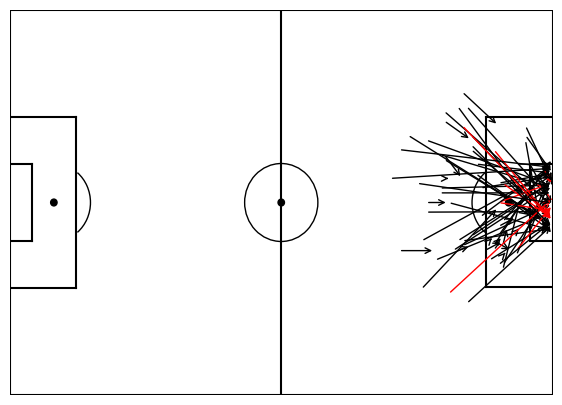

In [33]:
shot_data = all_france[(all_france['type_name'] == "Shot") & (all_france['team_name'] == 'France')]

fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.axis('off')

for i in range(len(shot_data)):
    # can also differentiate different half by different color
    color = "red" if shot_data.iloc[i]['shot_outcome_name'] == "Goal" else "black"
    ax.annotate("", xy = (shot_data.iloc[i]['shot_end_location'][0], shot_data.iloc[i]['shot_end_location'][1]), xycoords = 'data',
           xytext = (shot_data.iloc[i]['location'][0], shot_data.iloc[i]['location'][1]), textcoords = 'data',
           arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = color),)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.show()

The plot is not terribly useful but we can see that a majority of the French goals came from inside the 6-yard boxes. Even though they attempted a lot of long-range efforts, only three found the back of the net, including the stunner by Pavard during the semi-final

In [34]:
def draw_half_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([60,0], width = 60, height = 80, fill = False)
    #Right Penalty Area
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)

    #Right 6-yard Box
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = Arc((60,40),width = 8.1, height = 8.1, angle=0,theta1=270,theta2=90,color="black")
    centreSpot = plt.Circle((60,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    element = [Pitch, RightPenalty, RightSixYard, centreCircle, centreSpot, rightPenSpot, rightArc]
    for i in element:
        ax.add_patch(i)

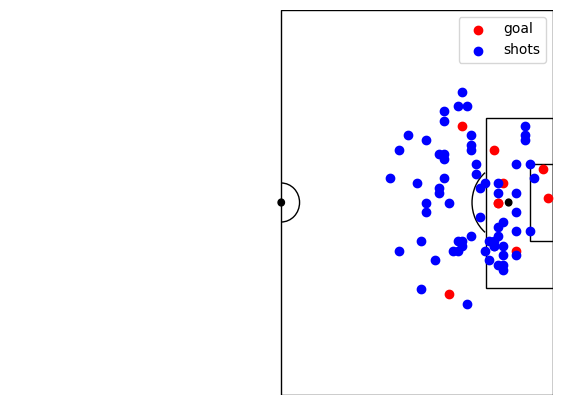

In [35]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_half_pitch(ax)
plt.axis('off')
# draw the scatter plot for goals
x_coord_goal = [location[0] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] == "Goal"]
y_coord_goal = [location[1] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] == "Goal"]
# shots that end up with no goal
x_coord = [location[0] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] != "Goal"]
y_coord = [location[1] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] != "Goal"]
# put the two scatter plots on to the pitch
ax.scatter(x_coord_goal, y_coord_goal, c = 'red', label = 'goal')
ax.scatter(x_coord, y_coord, c = 'blue', label = 'shots')
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

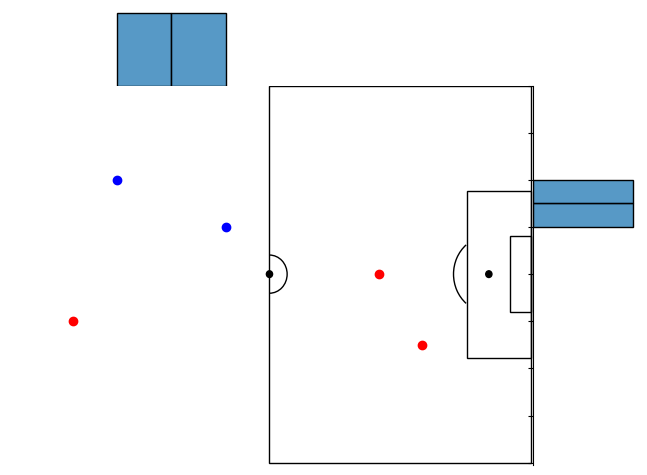

In [43]:
#joint plot to see the density of the shot distribution across the 2 axes of the pitch
joint_shot_chart = sns.jointplot(x=x_coord, y=y_coord, kind='scatter', space=0, alpha=0.5)
joint_shot_chart.fig.set_size_inches(7, 5)
ax = joint_shot_chart.ax_joint

# overlaying the plot with a pitch
draw_half_pitch(ax)
ax.set_xlim(0.5, 120.5)
ax.set_ylim(0.5, 80.5)

# draw the scatter plot for goals
x_coord_goal = [location[0] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] == "Goal"]
y_coord_goal = [location[1] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] == "Goal"]

# shots that end up with no goal
x_coord = [location[0] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] != "Goal"]
y_coord = [location[1] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] != "Goal"]

# put the two scatter plots on to the pitch
ax.scatter(x_coord, y_coord, c='b', label='shots')
ax.scatter(x_coord_goal, y_coord_goal, c='r', label='goal')

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
joint_shot_chart.ax_marg_x.set_axis_off()
ax.set_axis_off()
plt.ylim(-.5, 80)
plt.axis('off')
plt.show()


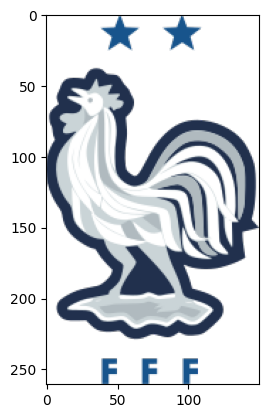

In [49]:
france = plt.imread("FFF.png")
plt.imshow(france)
plt.show()

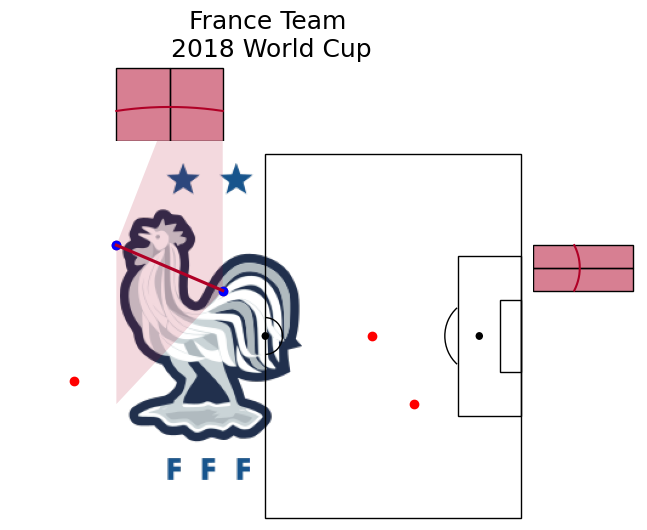

In [50]:
from matplotlib.offsetbox import OffsetImage
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.cm.YlOrRd_r  # import cmap
joint_shot_chart = sns.jointplot(x=x_coord, y=y_coord, kind='reg', space=0, color=cmap(0.1))
joint_shot_chart.fig.set_size_inches(7, 5)
ax = joint_shot_chart.ax_joint
draw_half_pitch(ax)
ax.set_xlim(0.5, 120.5)
ax.set_ylim(0.5, 80.5)

# draw the scatter plot for goals
x_coord_goal = [location[0] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] == "Goal"]
y_coord_goal = [location[1] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] == "Goal"]

# shots that end up with no goal
x_coord = [location[0] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] != "Goal"]
y_coord = [location[1] for i, location in enumerate(shot_data["location"]) if shot_data.iloc[i]['shot_outcome_name'] != "Goal"]

# put the two scatter plots on to the pitch
ax.scatter(x_coord, y_coord, c='b', label='shots')
ax.scatter(x_coord_goal, y_coord_goal, c='r', label='goal')

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('France Team \n2018 World Cup', y=1.2, fontsize=18)
joint_shot_chart.ax_marg_x.set_axis_off()
joint_shot_chart.ax_marg_y.set_axis_off()

# Add image
img = OffsetImage(france, zoom=0.873)
img.set_offset((120, 50))  # Play around with the coordinate until you find a good place
ax.add_artist(img)
ax.set_axis_off()
plt.xlim(0, 123)
plt.ylim(-0.5, 83)
plt.axis('off')
plt.show()


##### 4. Tree map for all Germany matches

Similarly, first we read all the Germany matches detail into the same dataframe

In [52]:
data_id = [7567, 7534, 7551]
# consequently read the json and concatenate into a pre-defined dataframe
germany_all = pd.DataFrame()
for i in data_id:
    try:
        # Added a try-except block to handle file not found errors
        with open('./'+str(i)+'.json') as data_file:
            data = json.load(data_file)
        df = json_normalize(data, sep = '_')
        if all_france.empty:
            germany_all = df
        else:
            germany_all = pd.concat([germany_all, df], join = 'outer', sort = False)
    except FileNotFoundError:
        # Print an error message if the file is not found
        print(f"File './{i}.json' not found. Skipping...")

In [53]:
germany_all = germany_all[germany_all.team_name == "Germany"]

Let's say we are interested in the following statistics per player across the tournament
- Total number of dribbles
- Total number of completed dribbles
- Total number of passes
- Total number of failed passes
- Total number of dispossession

In [54]:
# count total number of dribble
total_dribble = germany_all.groupby('player_name')['type_name'].apply(lambda x:(x=='Dribble').sum()).reset_index(name='total_dribble')
# number of dribble completed
dribble_complete= germany_all.groupby('player_name')['dribble_outcome_name'].apply(lambda x: (x=='Complete').sum()).reset_index(name='dribble_completed')
# total number of pass
total_pass = germany_all.groupby('player_name')['type_name'].apply(lambda x: (x=='Pass').sum()).reset_index(name='total_pass')
# number of incomplete pass
pass_incomplete = germany_all.groupby('player_name')['pass_outcome_name'].count().reset_index(name='incomplete_pass')
# number of times being dispossessed
dispossessed = germany_all.groupby('player_name')['type_name'].apply(lambda x: (x=='Dispossessed').sum()).reset_index(name='dispossessed')

In [55]:
df_list = [total_dribble, dribble_complete, total_pass, pass_incomplete, dispossessed]
summary_data = reduce(lambda x, y: pd.merge(x, y, on = 'player_name'), df_list)
summary_data

,player_name,total_dribble,dribble_completed,total_pass,incomplete_pass,dispossessed
0,Antonio Rüdiger,0,0,86,6,1
1,Jonas Hector,2,1,107,16,0
2,Joshua Kimmich,2,1,265,47,0
3,Julian Brandt,3,1,25,2,0
4,Julian Draxler,7,5,81,9,2
5,Jérôme Boateng,0,0,184,22,2
6,Leon Goretzka,1,1,22,2,0
7,Manuel Neuer,2,1,79,11,0
8,Marco Reus,2,1,126,23,1
9,Mario Gómez García,0,0,13,6,0


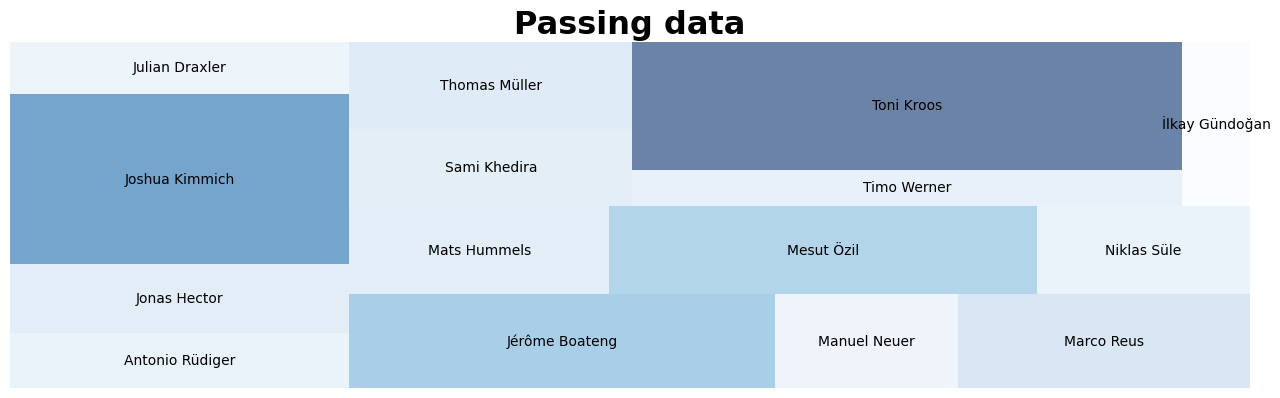

In [57]:
# New dataframe, containing only players with more than 50 passes
dataPass= summary_data[summary_data["total_pass"]>50]

# Import the necessary modules
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

#Utilise matplotlib to scale our goal numbers between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(dataPass.total_pass), vmax=max(dataPass.total_pass))
colors = [matplotlib.cm.Blues(norm(value)) for value in dataPass.total_pass]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=dataPass.player_name,sizes=dataPass.total_pass, color = colors, alpha=.6)
plt.title("Passing data",fontsize=23,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()

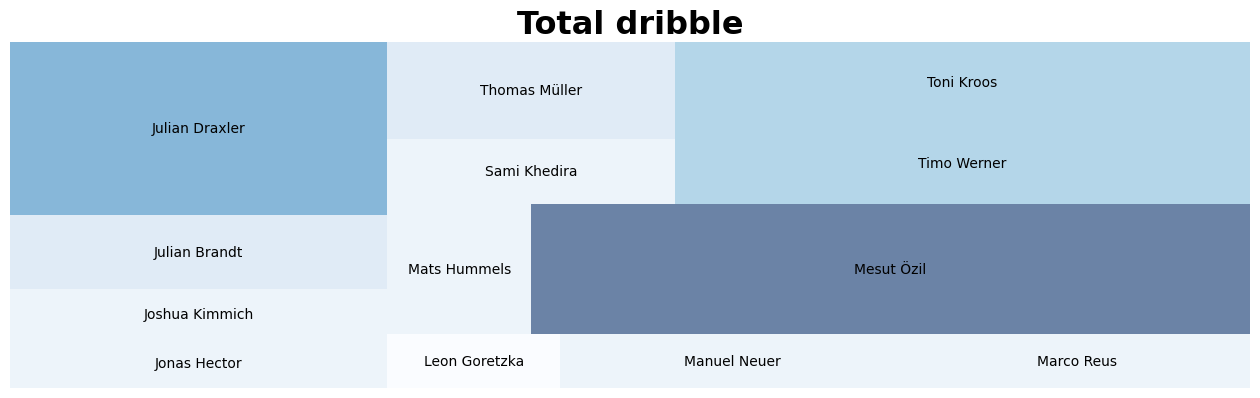

In [58]:
dataDribble= summary_data[summary_data["total_dribble"]>0]
#Utilise matplotlib to scale our goal numbers between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(dataDribble.total_dribble), vmax=max(dataDribble.total_dribble))
colors = [matplotlib.cm.Blues(norm(value)) for value in dataDribble.total_dribble]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=dataDribble.player_name,sizes=dataDribble.total_dribble, color = colors, alpha=.6)
plt.title("Total dribble",fontsize=23,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()